This notebook shows how we computed the MAE for all ensembles 

In [1]:

from tensorflow.keras.layers import Input, Dense, Concatenate
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
import torch as to


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps



original_dim_input=109  # CBRAIN input node size

original_dim_output=int(112) # CBRAIN output node size 

original_dim_output_VED=int(113) # CBRAIN output node size 


# network parameters
input_shape = (original_dim_input,)
out_shape=(original_dim_output,)
intermediate_dim = 405

batch_size = 3551

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

out_vars_VED = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND','PRECT','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']


#loading the output normalization scalars for SP variables ( stds over 3 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values

NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values





# defining the scaling dict for the VAE training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PRECT': 1/PRECT_std,
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}







from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai


PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];
import torch.nn as nn
import torch.nn.functional as F

2024-01-31 14:54:22.236899: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#load test data

val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

In [3]:
# load test data for VED

val_gen_III = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars_VED,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

# Load Networks 

In [4]:
ANN_1_lin=to.jit.load('real_geography/ANNs/ANN_1/ANN_1_CRM_lin_jit.pt')
ANN_2_lin=to.jit.load('real_geography/ANNs/ANN_2/ANN_2_CRM_lin_jit.pt')
ANN_3_lin=to.jit.load('real_geography/ANNs/ANN_3/ANN_3_CRM_lin_jit.pt')
ANN_4_lin=to.jit.load('real_geography/ANNs/ANN_4/ANN_4_CRM_lin_jit.pt')
ANN_5_lin=to.jit.load('real_geography/ANNs/ANN_5/ANN_5_CRM_lin_jit.pt')
ANN_6_lin=to.jit.load('real_geography/ANNs/ANN_6/ANN_6_CRM_lin_jit.pt')
ANN_7_lin=to.jit.load('real_geography/ANNs/ANN_7/ANN_7_CRM_lin_jit.pt')


In [5]:
VEnc_1=to.jit.load('real_geography/VEDs/VED_1/VEncoder_1_torch_jit.pt')
VDec_1=to.jit.load('real_geography/VEDs/VED_1/VDecoder_1_torch_jit.pt')
VEnc_2=to.jit.load('real_geography/VEDs/VED_2/VEncoder_2_torch_jit.pt')
VDec_2=to.jit.load('real_geography/VEDs/VED_2/VDecoder_2_torch_jit.pt')
VEnc_3=to.jit.load('real_geography/VEDs/VED_3/VEncoder_3_torch_jit.pt')
VDec_3=to.jit.load('real_geography/VEDs/VED_3/VDecoder_3_torch_jit.pt')
VEnc_4=to.jit.load('real_geography/VEDs/VED_4/VEncoder_4_torch_jit.pt')
VDec_4=to.jit.load('real_geography/VEDs/VED_4/VDecoder_4_torch_jit.pt')
VEnc_5=to.jit.load('real_geography/VEDs/VED_5/VEncoder_5_torch_jit.pt')
VDec_5=to.jit.load('real_geography/VEDs/VED_5/VDecoder_5_torch_jit.pt')
VEnc_7=to.jit.load('real_geography/VEDs/VED_7/VEncoder_7_torch_jit.pt')
VDec_7=to.jit.load('real_geography/VEDs/VED_7/VDecoder_7_torch_jit.pt')



In [6]:
ANN_1_lin_dr_01=to.jit.load('real_geography/ANNs/ANN_1/ANN_1_lin_dr_out_0_01_torch_jit.pt')


# Calculate MAE for ensembles and networks  

In [7]:
def MAE_calc_ens_lin(data_set,number_of_networks,stoch_ensemble):
    
    """
    calculate MAEs for multi-ANN ensembles 
    
    author: G. Behrens
    """
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output))
    MAE=np.nan*np.zeros((int(96*144),original_dim_output))
    ens=np.zeros((number_of_networks,int(96*144),original_dim_output))
    
    for i in tqdm(np.arange(data_set.n_batches)):
        stoch_ens_mem=np.random.choice(number_of_networks,stoch_ensemble,replace=False)
        ens[0,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[1,:,:]=data_set.output_transform.inverse_transform(ANN_2_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[2,:,:]=data_set.output_transform.inverse_transform(ANN_3_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[3,:,:]=data_set.output_transform.inverse_transform(ANN_4_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[4,:,:]=data_set.output_transform.inverse_transform(ANN_5_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[5,:,:]=data_set.output_transform.inverse_transform(ANN_6_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[6,:,:]=data_set.output_transform.inverse_transform(ANN_7_lin((to.from_numpy(data_set[i][0]))).detach().numpy())
        
        pred[i]=np.mean(ens[stoch_ens_mem],0)
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        MAE[k]=np.abs(np.nanmean((np.squeeze(pred[:,k,:])-np.squeeze(true[:,k,:])),0))
    del pred, true,ens
    return MAE

In [ ]:
ANN_lin_MAE_ens_7=MAE_calc_ens_lin(val_gen_II,7,7)
#np.save('MAE_real_geo/deter_7_ANN_lin_MAE',ANN_lin_MAE_ens_7)


In [ ]:
ANN_lin_MAE_stoch_5=MAE_calc_ens_lin(val_gen_II,7,5)
#np.save('MAE_real_geo/stoch_5_ANN_lin_MAE',ANN_lin_MAE_stoch_5)



In [8]:
def MAE_calc_ens_VED_ori(data_set,number_of_networks,stoch_ensemble):
    
    
    """
    calculate MAE for multi-VED ensemble 
    
    author: G. Behrens
    """
    
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    MAE=np.nan*np.zeros((int(96*144),113))
    ens=np.zeros((number_of_networks,int(96*144),113))
    
    for i in tqdm(np.arange(data_set.n_batches)):
        stoch_ens_mem=np.random.choice(number_of_networks,stoch_ensemble,replace=False)
        ens[0,:,:]=data_set.output_transform.inverse_transform(VDec_1(VEnc_1((to.from_numpy(data_set[i][0])))).detach().numpy())
        ens[1,:,:]=data_set.output_transform.inverse_transform(VDec_2(VEnc_2((to.from_numpy(data_set[i][0])))).detach().numpy())
        ens[2,:,:]=data_set.output_transform.inverse_transform(VDec_3(VEnc_3((to.from_numpy(data_set[i][0])))).detach().numpy())
        ens[3,:,:]=data_set.output_transform.inverse_transform(VDec_4(VEnc_4((to.from_numpy(data_set[i][0])))).detach().numpy())
        ens[4,:,:]=data_set.output_transform.inverse_transform(VDec_5(VEnc_5((to.from_numpy(data_set[i][0])))).detach().numpy())
        ens[5,:,:]=data_set.output_transform.inverse_transform(VDec_7(VEnc_7((to.from_numpy(data_set[i][0])))).detach().numpy())
        
        pred[i]=np.mean(ens[stoch_ens_mem],0)
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        MAE[k]=np.abs(np.nanmean((np.squeeze(pred[:,k,:])-np.squeeze(true[:,k,:])),0))
    del pred, true,ens
    return MAE

In [ ]:
VED_MAE_ens_6_ori=MAE_calc_ens_VED_ori(val_gen_III,6,6)
#np.save('MAE_real_geo/det_VED_6_MAE',VED_MAE_ens_6_ori)


In [9]:
def MAE_calc_ens_VED_intern(VDecoder,VEncoder,data_set,number_of_networks,stoch_ensemble,noise_level):
    
    
    
    """
    calculate MAE for stochastic VED ensembles with isotropic guassian latent space manipulation
    
    noise_level: magnitude of isotropic latent space manipulation
    
    author: G. Behrens
    """
    
    
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    MAE=np.nan*np.zeros((int(96*144),113))
    ens=np.zeros((number_of_networks,int(96*144),113))
    st_norm_perturb=np.nan*np.zeros((number_of_networks,int(96*144),VEncoder.z_log_var.weight.size()[0]))

    for i in tqdm(np.arange(data_set.n_batches)):
        stoch_ens_mem=np.random.choice(number_of_networks,stoch_ensemble,replace=False)
        st_norm_perturb=to.from_numpy(np.random.standard_normal((st_norm_perturb.shape)))

        ens[0]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[0],alpha=noise_level).float()).detach().numpy())
        ens[1]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[1],alpha=noise_level).float()).detach().numpy())
        ens[2]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[2],alpha=noise_level).float()).detach().numpy())
        ens[3]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[3],alpha=noise_level).float()).detach().numpy())
        ens[4]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[4],alpha=noise_level).float()).detach().numpy())
        ens[5]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[5],alpha=noise_level).float()).detach().numpy())
        ens[6]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[i][0]).float()),st_norm_perturb[6],alpha=noise_level).float()).detach().numpy())
        
        pred[i]=np.mean(ens[stoch_ens_mem],0)
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        MAE[k]=np.abs(np.nanmean((np.squeeze(pred[:,k,:])-np.squeeze(true[:,k,:])),0))
    del pred, true,ens
    
    return MAE

In [ ]:
VED_1_7_0=MAE_calc_ens_VED_intern(VDec_1,VEnc_1,val_gen_III,7,7,0)
#np.save('MAE_real_geo/stoch_VED_1_7_0_MAE',VED_1_7_0)


In [ ]:
VED_1_7_0_5=MAE_calc_ens_VED_intern(VDec_1,VEnc_1,val_gen_III,7,7,0.5)
#np.save('MAE_real_geo/stoch_VED_1_7_0_5_MAE',VED_1_7_0_5)


In [10]:
def MAE_calc_ens_VED_intern_alpha_sens(VDecoder,VEncoder,data_set,number_of_networks,stoch_ensemble,noise_level):
    
    
    """
    calculate MAE for stochastic VED ensembles with anisotropic guassian latent space manipulation
    
    noise_level: magnitude of anisotropic latent space manipulation

    
    author: G. Behrens
    """
    
    
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    MAE=np.nan*np.zeros((int(96*144),113))
    ens=np.zeros((number_of_networks,int(96*144),113))
    st_norm_perturb=np.nan*np.zeros((number_of_networks,int(96*144),VEncoder.z_log_var.weight.size()[0]))

    for i in tqdm(np.arange(data_set.n_batches)):
        stoch_ens_mem=np.random.choice(number_of_networks,stoch_ensemble,replace=False)
        st_norm_perturb=to.from_numpy(np.random.standard_normal((st_norm_perturb.shape)))

        ens[0]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[0]).float()).detach().numpy())
        ens[1]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[1]).float()).detach().numpy())
        ens[2]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[2]).float()).detach().numpy())
        ens[3]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[3]).float()).detach().numpy())
        ens[4]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[4]).float()).detach().numpy())
        ens[5]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[5]).float()).detach().numpy())
        ens[6]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[6]).float()).detach().numpy())
        
        pred[i]=np.mean(ens[stoch_ens_mem],0)
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        MAE[k]=np.abs(np.nanmean((np.squeeze(pred[:,k,:])-np.squeeze(true[:,k,:])),0))
    del pred, true,ens
    
    return MAE

In [ ]:
VED_1_7_alpha_1_MAE=MAE_calc_ens_VED_intern_alpha_sens(VDec_1,VEnc_1,val_gen_III,7,7,np.load('alpha_arrs/alpha_1.npy'))
#np.save('MAE_real_geo/stoch_VED_1_7_alpha_1_MAE',VED_1_7_alpha_1_MAE)


In [11]:
def MAE_calc_ens_lin_dr(data_set,number_of_networks,stoch_ensemble):
    
    """
    calculate MAE for ANN-dropout

    
    author: G. Behrens
    """
    
    
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output))
    MAE_1=np.nan*np.zeros((int(96*144),original_dim_output))
    ens=np.zeros((number_of_networks,int(96*144),original_dim_output))
    
    for i in tqdm(np.arange(data_set.n_batches)):
        stoch_ens_mem=np.random.choice(number_of_networks,stoch_ensemble,replace=False)
        ens[0,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[1,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[2,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[3,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[4,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[5,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        ens[6,:,:]=data_set.output_transform.inverse_transform(ANN_1_lin_dr_01((to.from_numpy(data_set[i][0]))).detach().numpy())
        
        pred[i]=np.mean(ens[stoch_ens_mem],0)
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        MAE_1[k]=np.abs(np.nanmean((np.squeeze(pred[:,k,:])-np.squeeze(true[:,k,:])),0))
    del pred, true,ens
    return MAE_1

In [ ]:
ANN_1_lin_dr_01_MAE_7_mem=MAE_calc_ens_lin_dr(val_gen_II,7,7)
#np.save('MAE_real_geo/ANN_1_lin_dr_0_01_7_mem_MAE',ANN_1_lin_dr_01_MAE_7_mem)


In [12]:
def MAE_calc(Network,data_set):
    """
    calculate MAE for individual ANNs 
    
    """
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),original_dim_output))
    MAE=np.nan*np.zeros((int(96*144),original_dim_output))
    
    
    for i in tqdm(np.arange(data_set.n_batches)):
        pred[i]=data_set.output_transform.inverse_transform(Network(to.from_numpy(data_set[i][0])).detach().numpy())
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        MAE[k]=np.abs(np.nanmean((np.squeeze(pred[:,k,:])-np.squeeze(true[:,k,:])),0))
    del pred, true
    return MAE

In [ ]:
ANN_1_lin_MAE=MAE_calc(ANN_1_lin,val_gen_II)
ANN_2_lin_MAE=MAE_calc(ANN_2_lin,val_gen_II)
ANN_3_lin_MAE=MAE_calc(ANN_3_lin,val_gen_II)
ANN_4_lin_MAE=MAE_calc(ANN_4_lin,val_gen_II)
ANN_5_lin_MAE=MAE_calc(ANN_5_lin,val_gen_II)
ANN_6_lin_MAE=MAE_calc(ANN_6_lin,val_gen_II)
ANN_7_lin_MAE=MAE_calc(ANN_7_lin,val_gen_II)



#np.save('MAE_real_geo/ANN_1_lin_MAE',ANN_1_lin_MAE)
#np.save('MAE_real_geo/ANN_2_lin_MAE',ANN_2_lin_MAE)
#np.save('MAE_real_geo/ANN_3_lin_MAE',ANN_3_lin_MAE)
#np.save('MAE_real_geo/ANN_4_lin_MAE',ANN_4_lin_MAE)
#np.save('MAE_real_geo/ANN_5_lin_MAE',ANN_5_lin_MAE)
#np.save('MAE_real_geo/ANN_6_lin_MAE',ANN_6_lin_MAE)
#np.save('MAE_real_geo/ANN_7_lin_MAE',ANN_7_lin_MAE)


In [ ]:
def MAE_calc_VED(Enc,Dec,data_set):
    """
    calculate MAE for individual VEDs 
    
    """
    
    pred=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    true=np.nan*np.zeros((data_set.n_batches,int(96*144),113))
    MAE=np.nan*np.zeros((int(96*144),113))
    
    
    for i in tqdm(np.arange(data_set.n_batches)):
        pred[i]=data_set.output_transform.inverse_transform(Dec(Enc(to.from_numpy(data_set[i][0]))).detach().numpy())
        true[i]=data_set.output_transform.inverse_transform(to.from_numpy(data_set[i][1]).detach().numpy())
        
    for k in tqdm(np.arange(pred[0,:,1].size)):
        
        MAE[k]=np.abs(np.nanmean((np.squeeze(pred[:,k,:])-np.squeeze(true[:,k,:])),0))
    del pred, true
    return MAE

In [ ]:
VED_1_MAE=MAE_calc_VED(VEnc_1,VDec_1,val_gen_III)
VED_2_MAE=MAE_calc_VED(VEnc_2,VDec_2,val_gen_III)
VED_3_MAE=MAE_calc_VED(VEnc_3,VDec_3,val_gen_III)
VED_4_MAE=MAE_calc_VED(VEnc_4,VDec_4,val_gen_III)
VED_5_MAE=MAE_calc_VED(VEnc_5,VDec_5,val_gen_III)
VED_7_MAE=MAE_calc_VED(VEnc_7,VDec_7,val_gen_III)


#np.save('MAE_real_geo/VED_1_MAE',VED_1_MAE)
#np.save('MAE_real_geo/VED_2_MAE',VED_2_MAE)
#np.save('MAE_real_geo/VED_3_MAE',VED_3_MAE)
#np.save('MAE_real_geo/VED_4_MAE',VED_4_MAE)
#np.save('MAE_real_geo/VED_5_MAE',VED_5_MAE)
#np.save('MAE_real_geo/VED_7_MAE',VED_7_MAE)



# Load saved MAEs

In [7]:
ANN_1_lin_MAE=np.load('MAE_real_geo/ANN_1_lin_MAE.npy')
ANN_2_lin_MAE=np.load('MAE_real_geo/ANN_2_lin_MAE.npy')
ANN_3_lin_MAE=np.load('MAE_real_geo/ANN_3_lin_MAE.npy')
ANN_4_lin_MAE=np.load('MAE_real_geo/ANN_4_lin_MAE.npy')
ANN_5_lin_MAE=np.load('MAE_real_geo/ANN_5_lin_MAE.npy')
ANN_6_lin_MAE=np.load('MAE_real_geo/ANN_6_lin_MAE.npy')
ANN_7_lin_MAE=np.load('MAE_real_geo/ANN_7_lin_MAE.npy')



In [8]:
VED_1_MAE=np.load('MAE_real_geo/VED_1_MAE.npy')
VED_2_MAE=np.load('MAE_real_geo/VED_2_MAE.npy')
VED_3_MAE=np.load('MAE_real_geo/VED_3_MAE.npy')
VED_4_MAE=np.load('MAE_real_geo/VED_4_MAE.npy')
VED_5_MAE=np.load('MAE_real_geo/VED_5_MAE.npy')
VED_7_MAE=np.load('MAE_real_geo/VED_7_MAE.npy')


In [9]:
ANN_1_lin_dr_01_MAE_7_mem=np.load('MAE_real_geo/ANN_1_lin_dr_0_01_7_mem_MAE.npy')
deter_7_lin=np.load('MAE_real_geo/deter_7_ANN_lin_MAE.npy')
stoch_5_lin=np.load('MAE_real_geo/stoch_5_ANN_lin_MAE.npy')
VED_1_7_0_5=np.load('MAE_real_geo/stoch_VED_1_7_0_5_MAE.npy')
VED_1_7_1=np.load('MAE_real_geo/stoch_VED_1_7_1_MAE.npy')
VED_1_7_0=np.load('MAE_real_geo/stoch_VED_1_7_0_MAE.npy')
VED_deter_6=np.load('MAE_real_geo/det_VED_6_MAE.npy')
VED_1_7_alpha_1_MAE=np.load('MAE_real_geo/stoch_VED_1_7_alpha_1_MAE.npy')

# Plot results 

Text(0.5, 1.0, 'd) $\\mathbf{\\dot{q}_{ci}}$(p)')

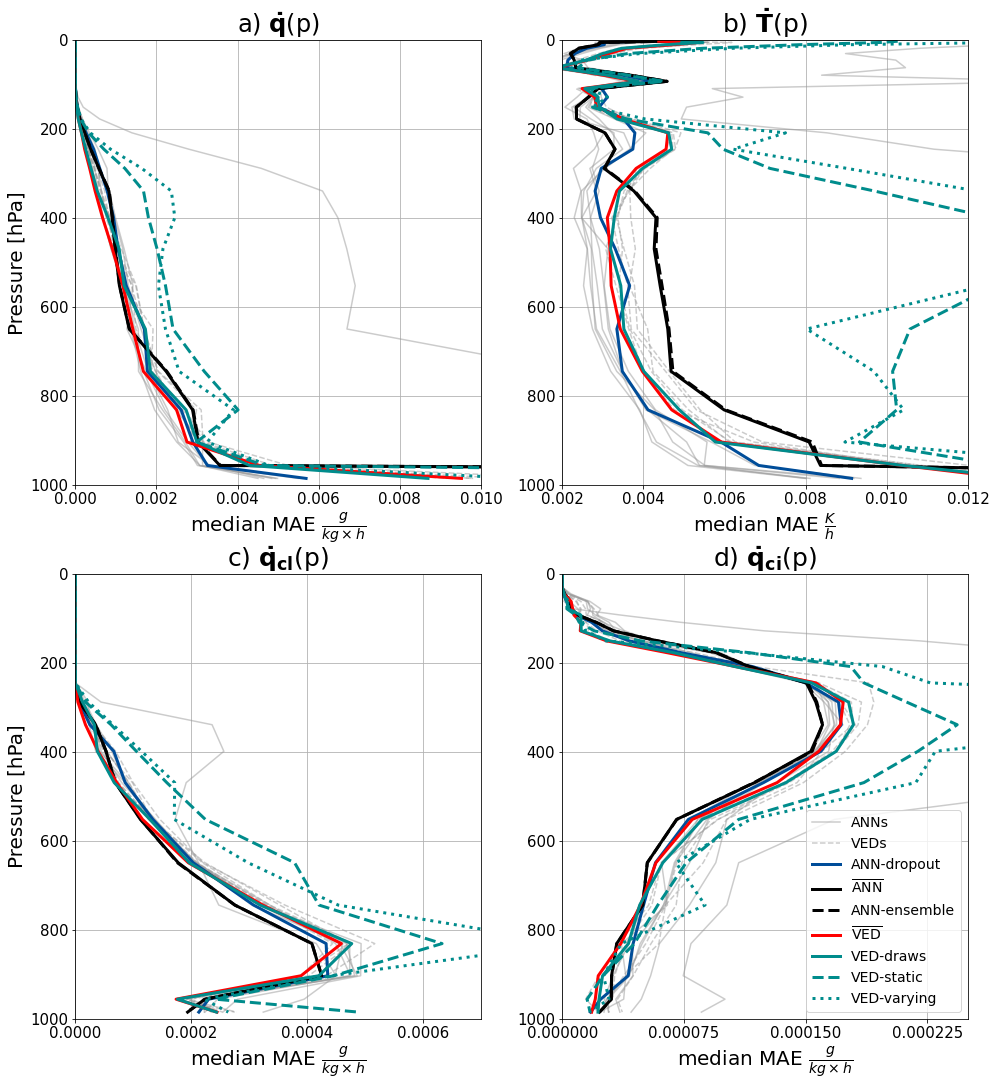

In [17]:

plt.figure(1,(16,18))
plt.subplot(2,2,1)


plt.plot(np.nanmedian(3600*1000*ANN_1_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_2_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_3_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_4_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_5_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_6_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_7_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(3600*1000*VED_1_MAE[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_2_MAE[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_3_MAE[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_4_MAE[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_5_MAE[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_7_MAE[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 7$_{median}$')




plt.plot(np.nanmedian(3600*1000*ANN_1_lin_dr_01_MAE_7_mem[:,0:26],0),P[0:26]/100
        ,linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(np.nanmedian(3600*1000*deter_7_lin[:,0:26],0),P[0:26]/100,linewidth=3,color='k',label=r'$\overline{\mathrm{ANN_i}}$')
plt.plot(np.nanmedian(3600*1000*stoch_5_lin[:,0:26],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(np.nanmedian(3600*1000*VED_deter_6[:,0:26],0),P[0:26]/100,linewidth=3,color='r',label=r'$\overline{\mathrm{VED_i}}$')

plt.plot(np.nanmedian(3600*1000*VED_1_7_0[:,0:26],0),P[0:26]/100,linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')

plt.plot(np.nanmedian(3600*1000*VED_1_7_0_5[:,0:26],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(3600*1000*VED_1_7_alpha_1_MAE[:,0:26],0),P[0:26]/100,':',linewidth=3,
         color=[0,0.55,0.55],label=r'VED-varying')

sr=plt.gca()
plt.xlim(0,0.010)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'median MAE $\frac{g}{kg \times h}$',fontsize=20)

plt.title('a) $\mathbf{\dot{q}}$(p)',fontsize=24)



plt.subplot(2,2,2)


plt.plot(np.nanmedian(3600*ANN_1_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(3600*ANN_2_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(3600*ANN_3_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(3600*ANN_4_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(3600*ANN_5_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(3600*ANN_6_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(3600*ANN_7_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(3600*VED_1_MAE[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(3600*VED_2_MAE[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(3600*VED_3_MAE[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(3600*VED_4_MAE[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(3600*VED_5_MAE[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(3600*VED_7_MAE[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 7$_{median}$')




plt.plot(np.nanmedian(3600*ANN_1_lin_dr_01_MAE_7_mem[:,26:52],0),P[0:26]/100
        ,linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(np.nanmedian(3600*deter_7_lin[:,26:52],0),P[0:26]/100,linewidth=3,color='k',label=r'$\overline{\mathrm{ANN_i}}$')
plt.plot(np.nanmedian(3600*stoch_5_lin[:,26:52],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(np.nanmedian(3600*VED_deter_6[:,26:52],0),P[0:26]/100,linewidth=3,color='r',label=r'$\overline{\mathrm{VED_i}}$')

plt.plot(np.nanmedian(3600*VED_1_7_0[:,26:52],0),P[0:26]/100,linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')


plt.plot(np.nanmedian(3600*VED_1_7_0_5[:,26:52],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(3600*VED_1_7_alpha_1_MAE[:,26:52],0),P[0:26]/100,':',linewidth=3,
         color=[0,0.55,0.55],label=r'VED-varying')


sr=plt.gca()
plt.xlim(0.002,0.012)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'median MAE $\frac{K}{h}$',fontsize=20)
plt.title('b) $\mathbf{\dot{T}}$(p)',fontsize=25)




plt.subplot(2,2,3)


plt.plot(np.nanmedian(3600*1000*ANN_1_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_2_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_3_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_4_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_5_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_6_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_7_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(3600*1000*VED_1_MAE[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_2_MAE[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_3_MAE[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_4_MAE[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_5_MAE[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_7_MAE[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 7$_{median}$')



plt.plot(np.nanmedian(3600*1000*ANN_1_lin_dr_01_MAE_7_mem[:,52:78],0),P[0:26]/100,
         linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(np.nanmedian(3600*1000*deter_7_lin[:,52:78],0),P[0:26]/100,linewidth=3,color='k',label=r'$\overline{\mathrm{ANN_i}}$')
plt.plot(np.nanmedian(3600*1000*stoch_5_lin[:,52:78],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(np.nanmedian(3600*1000*VED_deter_6[:,52:78],0),P[0:26]/100,linewidth=3,color='r',label=r'$\overline{\mathrm{VED_i}}$')

plt.plot(np.nanmedian(3600*1000*VED_1_7_0[:,52:78],0),P[0:26]/100,linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')
plt.plot(np.nanmedian(3600*1000*VED_1_7_0_5[:,52:78],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(3600*1000*VED_1_7_alpha_1_MAE[:,52:78],0),P[0:26]/100,':',linewidth=3,
         color=[0,0.55,0.55],label=r'VED-varying')


sr=plt.gca()
plt.xlim(0,0.0007)
plt.xticks(np.arange(0,7E-4,2E-4))
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Pressure [hPa]',fontsize=20)

plt.xlabel(r'median MAE $\frac{g}{kg \times h}$',fontsize=20)
plt.title(r'c) $\mathbf{\dot{q}_{cl}}$(p)',fontsize=25)

plt.subplot(2,2,4)


plt.plot(np.nanmedian(3600*1000*ANN_1_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANNs')
plt.plot(np.nanmedian(3600*1000*ANN_2_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_3_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_4_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_5_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_6_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_7_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(3600*1000*VED_1_MAE[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VEDs')
plt.plot(np.nanmedian(3600*1000*VED_2_MAE[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_3_MAE[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_4_MAE[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_5_MAE[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_7_MAE[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 7$_{median}$')




plt.plot(np.nanmedian(3600*1000*ANN_1_lin_dr_01_MAE_7_mem[:,78:104],0),P[0:26]/100,
         linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(np.nanmedian(3600*1000*deter_7_lin[:,78:104],0),P[0:26]/100,linewidth=3,color='k',label=r'$\overline{\mathrm{ANN}}$')
plt.plot(np.nanmedian(3600*1000*stoch_5_lin[:,78:104],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(np.nanmedian(3600*1000*VED_deter_6[:,78:104],0),P[0:26]/100,linewidth=3,color='r',label=r'$\overline{\mathrm{VED}}$')

plt.plot(np.nanmedian(3600*1000*VED_1_7_0[:,78:104],0),P[0:26]/100,linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')
plt.plot(np.nanmedian(3600*1000*VED_1_7_0_5[:,78:104],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(3600*1000*VED_1_7_alpha_1_MAE[:,78:104],0),P[0:26]/100,':',linewidth=3,
         color=[0,0.55,0.55],label=r'VED-varying')

sr=plt.gca()
plt.xlim(0,0.00025)
plt.xticks(np.arange(0,2.5E-4,0.75E-4))
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.legend(fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'median MAE $\frac{g}{kg \times h}$',fontsize=20)
plt.title(r'd) $\mathbf{\dot{q}_{ci}}$(p)',fontsize=25)


Text(0.5, 1.0, 'd) $\\mathbf{\\dot{q}_{ci}}$(p)')

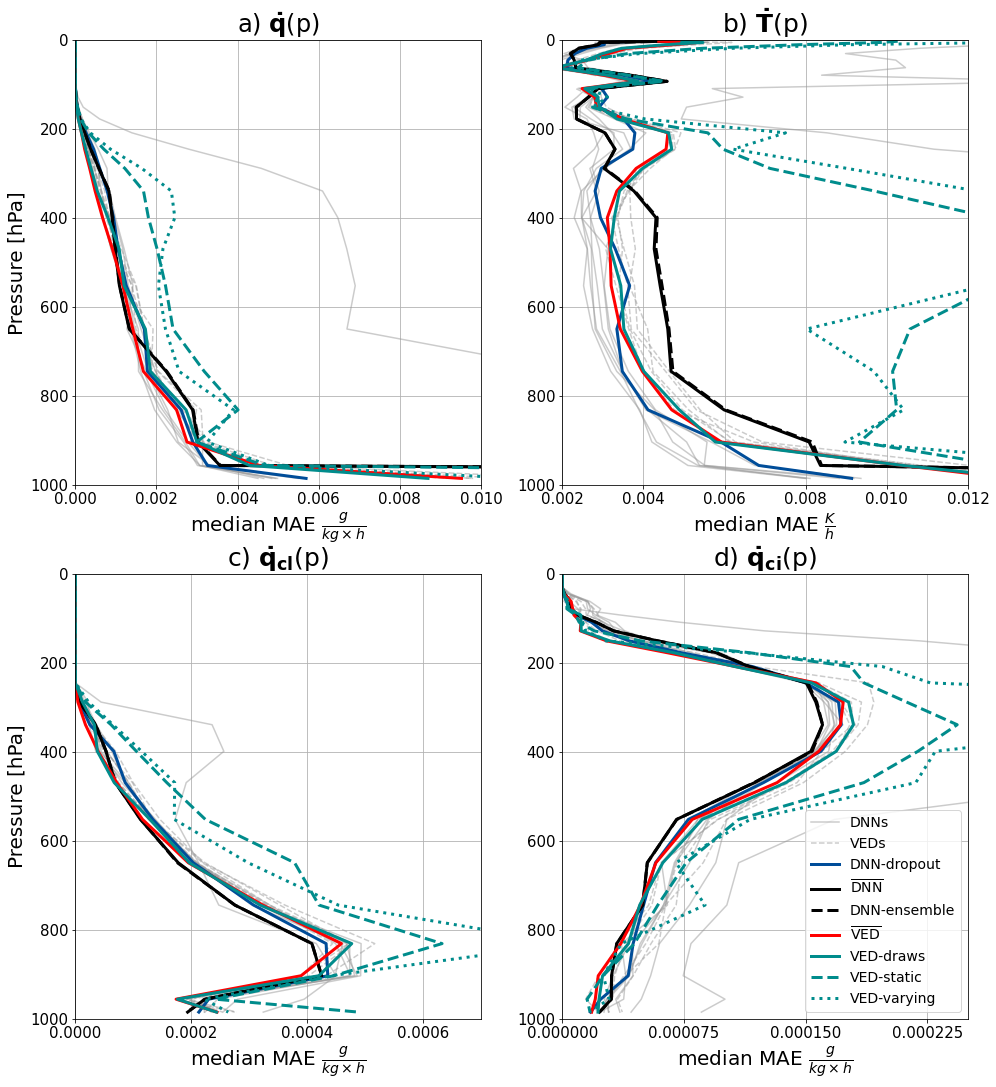

In [10]:

plt.figure(1,(16,18))
plt.subplot(2,2,1)


plt.plot(np.nanmedian(3600*1000*ANN_1_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_2_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_3_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_4_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_5_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_6_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_7_lin_MAE[:,0:26],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(3600*1000*VED_1_MAE[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_2_MAE[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_3_MAE[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_4_MAE[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_5_MAE[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_7_MAE[:,0:26],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 7$_{median}$')




plt.plot(np.nanmedian(3600*1000*ANN_1_lin_dr_01_MAE_7_mem[:,0:26],0),P[0:26]/100
        ,linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(np.nanmedian(3600*1000*deter_7_lin[:,0:26],0),P[0:26]/100,linewidth=3,color='k',label=r'$\overline{\mathrm{ANN_i}}$')
plt.plot(np.nanmedian(3600*1000*stoch_5_lin[:,0:26],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(np.nanmedian(3600*1000*VED_deter_6[:,0:26],0),P[0:26]/100,linewidth=3,color='r',label=r'$\overline{\mathrm{VED_i}}$')

plt.plot(np.nanmedian(3600*1000*VED_1_7_0[:,0:26],0),P[0:26]/100,linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')

plt.plot(np.nanmedian(3600*1000*VED_1_7_0_5[:,0:26],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(3600*1000*VED_1_7_alpha_1_MAE[:,0:26],0),P[0:26]/100,':',linewidth=3,
         color=[0,0.55,0.55],label=r'VED-varying')

sr=plt.gca()
plt.xlim(0,0.010)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.ylabel('Pressure [hPa]',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'median MAE $\frac{g}{kg \times h}$',fontsize=20)

plt.title('a) $\mathbf{\dot{q}}$(p)',fontsize=24)



plt.subplot(2,2,2)


plt.plot(np.nanmedian(3600*ANN_1_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(3600*ANN_2_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(3600*ANN_3_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(3600*ANN_4_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(3600*ANN_5_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(3600*ANN_6_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(3600*ANN_7_lin_MAE[:,26:52],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(3600*VED_1_MAE[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(3600*VED_2_MAE[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(3600*VED_3_MAE[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(3600*VED_4_MAE[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(3600*VED_5_MAE[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(3600*VED_7_MAE[:,26:52],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 7$_{median}$')




plt.plot(np.nanmedian(3600*ANN_1_lin_dr_01_MAE_7_mem[:,26:52],0),P[0:26]/100
        ,linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(np.nanmedian(3600*deter_7_lin[:,26:52],0),P[0:26]/100,linewidth=3,color='k',label=r'$\overline{\mathrm{ANN_i}}$')
plt.plot(np.nanmedian(3600*stoch_5_lin[:,26:52],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(np.nanmedian(3600*VED_deter_6[:,26:52],0),P[0:26]/100,linewidth=3,color='r',label=r'$\overline{\mathrm{VED_i}}$')

plt.plot(np.nanmedian(3600*VED_1_7_0[:,26:52],0),P[0:26]/100,linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')


plt.plot(np.nanmedian(3600*VED_1_7_0_5[:,26:52],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(3600*VED_1_7_alpha_1_MAE[:,26:52],0),P[0:26]/100,':',linewidth=3,
         color=[0,0.55,0.55],label=r'VED-varying')


sr=plt.gca()
plt.xlim(0.002,0.012)
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'median MAE $\frac{K}{h}$',fontsize=20)
plt.title('b) $\mathbf{\dot{T}}$(p)',fontsize=25)




plt.subplot(2,2,3)


plt.plot(np.nanmedian(3600*1000*ANN_1_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_2_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_3_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_4_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_5_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_6_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_7_lin_MAE[:,52:78],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(3600*1000*VED_1_MAE[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_2_MAE[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_3_MAE[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_4_MAE[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_5_MAE[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_7_MAE[:,52:78],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VED 7$_{median}$')



plt.plot(np.nanmedian(3600*1000*ANN_1_lin_dr_01_MAE_7_mem[:,52:78],0),P[0:26]/100,
         linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(np.nanmedian(3600*1000*deter_7_lin[:,52:78],0),P[0:26]/100,linewidth=3,color='k',label=r'$\overline{\mathrm{ANN_i}}$')
plt.plot(np.nanmedian(3600*1000*stoch_5_lin[:,52:78],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(np.nanmedian(3600*1000*VED_deter_6[:,52:78],0),P[0:26]/100,linewidth=3,color='r',label=r'$\overline{\mathrm{VED_i}}$')

plt.plot(np.nanmedian(3600*1000*VED_1_7_0[:,52:78],0),P[0:26]/100,linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')
plt.plot(np.nanmedian(3600*1000*VED_1_7_0_5[:,52:78],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(3600*1000*VED_1_7_alpha_1_MAE[:,52:78],0),P[0:26]/100,':',linewidth=3,
         color=[0,0.55,0.55],label=r'VED-varying')


sr=plt.gca()
plt.xlim(0,0.0007)
plt.xticks(np.arange(0,7E-4,2E-4))
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Pressure [hPa]',fontsize=20)

plt.xlabel(r'median MAE $\frac{g}{kg \times h}$',fontsize=20)
plt.title(r'c) $\mathbf{\dot{q}_{cl}}$(p)',fontsize=25)

plt.subplot(2,2,4)


plt.plot(np.nanmedian(3600*1000*ANN_1_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5],label=r'DNNs')
plt.plot(np.nanmedian(3600*1000*ANN_2_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_3_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_4_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_5_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_6_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(3600*1000*ANN_7_lin_MAE[:,78:104],0),P[0:26]/100,color=[0.6,0.6,0.6,0.5])#,label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(3600*1000*VED_1_MAE[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5],label=r'VEDs')
plt.plot(np.nanmedian(3600*1000*VED_2_MAE[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_3_MAE[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_4_MAE[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_5_MAE[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(3600*1000*VED_7_MAE[:,78:104],0),P[0:26]/100,'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 7$_{median}$')




plt.plot(np.nanmedian(3600*1000*ANN_1_lin_dr_01_MAE_7_mem[:,78:104],0),P[0:26]/100,
         linewidth=3,color=[0,0.3,0.6],label=r'DNN-dropout')
plt.plot(np.nanmedian(3600*1000*deter_7_lin[:,78:104],0),P[0:26]/100,linewidth=3,color='k',label=r'$\overline{\mathrm{DNN}}$')
plt.plot(np.nanmedian(3600*1000*stoch_5_lin[:,78:104],0),P[0:26]/100,'--',linewidth=3,color='k',label=r'DNN-ensemble')
plt.plot(np.nanmedian(3600*1000*VED_deter_6[:,78:104],0),P[0:26]/100,linewidth=3,color='r',label=r'$\overline{\mathrm{VED}}$')

plt.plot(np.nanmedian(3600*1000*VED_1_7_0[:,78:104],0),P[0:26]/100,linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')
plt.plot(np.nanmedian(3600*1000*VED_1_7_0_5[:,78:104],0),P[0:26]/100,'--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')

plt.plot(np.nanmedian(3600*1000*VED_1_7_alpha_1_MAE[:,78:104],0),P[0:26]/100,':',linewidth=3,
         color=[0,0.55,0.55],label=r'VED-varying')

sr=plt.gca()
plt.xlim(0,0.00025)
plt.xticks(np.arange(0,2.5E-4,0.75E-4))
plt.ylim(0,1000)
sr.invert_yaxis()
plt.grid(True)
plt.legend(fontsize=14)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'median MAE $\frac{g}{kg \times h}$',fontsize=20)
plt.title(r'd) $\mathbf{\dot{q}_{ci}}$(p)',fontsize=25)


In [11]:
SP_2D_VAR_2=[r'Snow$_{CRM}$','Prec$_{CRM}$',r'Q$_{lw \ surf}$',
           r'Q$_{sw \ surf}$',r'Q$_{sol \ lw}$',r'Q$_{sol \ lw, \ diff}$',
           r'Q$_{sol \ sw}$',r'Q$_{sol \ sw, \ diff}$']

Text(0.5, 1.0, '2D SPCESM variables')

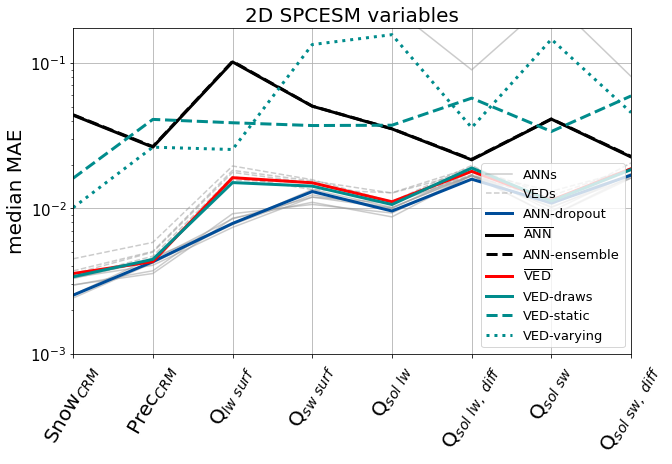

In [20]:
plt.figure(2,(10,6))

plt.plot(np.nanmedian(ANN_1_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5],label='ANNs')#,label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(ANN_2_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(ANN_3_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(ANN_4_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(ANN_5_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(ANN_6_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(ANN_7_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(VED_1_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),'--',color=[0.6,0.6,0.6,0.5],label='VEDs')#,label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(VED_2_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(VED_3_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(VED_4_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(VED_5_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(VED_7_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 7$_{median}$')



plt.plot(np.nanmedian(ANN_1_lin_dr_01_MAE_7_mem[:,104:112]*val_gen_II.output_transform.scale[104:112],0),
         linewidth=3,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(np.nanmedian(deter_7_lin[:,104:112]*val_gen_II.output_transform.scale[104:112],0),
         linewidth=3,color='k',label=r'$\overline{\mathrm{ANN}}$')
plt.plot(np.nanmedian(stoch_5_lin[:,104:112]*val_gen_II.output_transform.scale[104:112],0),
         '--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(np.nanmedian(VED_deter_6[:,105:113]*val_gen_II.output_transform.scale[104:112],0),linewidth=3,
         color='r',label=r'$\overline{\mathrm{VED}}$')

plt.plot(np.nanmedian(VED_1_7_0[:,105:113]*val_gen_II.output_transform.scale[104:112],0),
         color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.nanmedian(VED_1_7_0_5[:,105:113]*val_gen_II.output_transform.scale[104:112],0),
         '--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.plot(np.nanmedian(VED_1_7_alpha_1_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),
         ':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')





plt.grid(True)
plt.yscale('log')
plt.ylim(0.001,0.175)
plt.xlim(0,7)
plt.legend(fontsize=13,loc=4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(np.arange(ANN_1_lin_MAE[1,104:112].size),SP_2D_VAR_2, rotation=60,fontsize=20)

plt.ylabel(r'median MAE',fontsize=20)
plt.title('2D SPCESM variables',fontsize=20)


Text(0.5, 1.0, '2D SPCESM variables')

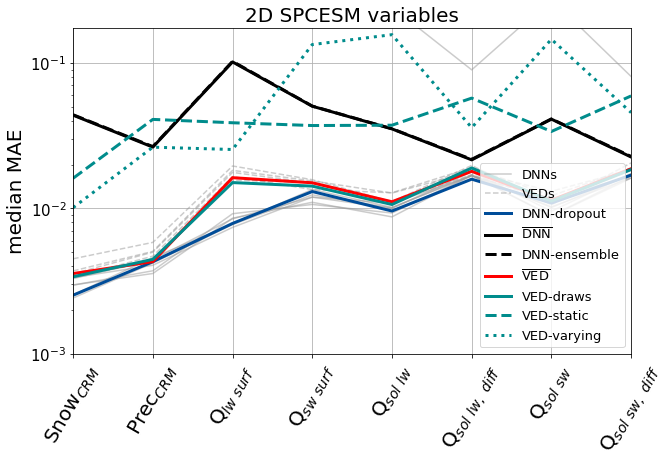

In [12]:
plt.figure(2,(10,6))

plt.plot(np.nanmedian(ANN_1_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5],label='DNNs')#,label=r'ANN 1$_{median}$')
plt.plot(np.nanmedian(ANN_2_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 2$_{median}$')
plt.plot(np.nanmedian(ANN_3_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 3$_{median}$')
plt.plot(np.nanmedian(ANN_4_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 4$_{median}$')
plt.plot(np.nanmedian(ANN_5_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 5$_{median}$')
plt.plot(np.nanmedian(ANN_6_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 6$_{median}$')
plt.plot(np.nanmedian(ANN_7_lin_MAE[:,104:112]*val_gen_II.output_transform.scale[104:112],0),color=[0.6,0.6,0.6,0.5])#,label=r'ANN 7$_{median}$')


plt.plot(np.nanmedian(VED_1_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),'--',color=[0.6,0.6,0.6,0.5],label='VEDs')#,label=r'VED 1$_{median}$')
plt.plot(np.nanmedian(VED_2_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 2$_{median}$')
plt.plot(np.nanmedian(VED_3_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 3$_{median}$')
plt.plot(np.nanmedian(VED_4_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 4$_{median}$')
plt.plot(np.nanmedian(VED_5_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 5$_{median}$')
plt.plot(np.nanmedian(VED_7_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),'--',color=[0.6,0.6,0.6,0.5])#,label=r'VED 7$_{median}$')



plt.plot(np.nanmedian(ANN_1_lin_dr_01_MAE_7_mem[:,104:112]*val_gen_II.output_transform.scale[104:112],0),
         linewidth=3,color=[0,0.3,0.6],label=r'DNN-dropout')
plt.plot(np.nanmedian(deter_7_lin[:,104:112]*val_gen_II.output_transform.scale[104:112],0),
         linewidth=3,color='k',label=r'$\overline{\mathrm{DNN}}$')
plt.plot(np.nanmedian(stoch_5_lin[:,104:112]*val_gen_II.output_transform.scale[104:112],0),
         '--',linewidth=3,color='k',label=r'DNN-ensemble')
plt.plot(np.nanmedian(VED_deter_6[:,105:113]*val_gen_II.output_transform.scale[104:112],0),linewidth=3,
         color='r',label=r'$\overline{\mathrm{VED}}$')

plt.plot(np.nanmedian(VED_1_7_0[:,105:113]*val_gen_II.output_transform.scale[104:112],0),
         color=[0,0.55,0.55],linewidth=3,label=r'VED-draws')

plt.plot(np.nanmedian(VED_1_7_0_5[:,105:113]*val_gen_II.output_transform.scale[104:112],0),
         '--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.plot(np.nanmedian(VED_1_7_alpha_1_MAE[:,105:113]*val_gen_II.output_transform.scale[104:112],0),
         ':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')





plt.grid(True)
plt.yscale('log')
plt.ylim(0.001,0.175)
plt.xlim(0,7)
plt.legend(fontsize=13,loc=4)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(np.arange(ANN_1_lin_MAE[1,104:112].size),SP_2D_VAR_2, rotation=60,fontsize=20)

plt.ylabel(r'median MAE',fontsize=20)
plt.title('2D SPCESM variables',fontsize=20)
